In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import time
from acquire import player_season_3pa
import explore
import wrangle

# Endpoints from NBA API
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import gamerotation
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import winprobabilitypbp

# Static Imports from NBA API
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [3]:
#calling in the data:
df, df_outlier_3pt, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.wrangle_prep()

Train = 47167 rows (56.0%) | Validate = 20215 rows (24.0%) | Test = 16846 rows (20.0%)


In [3]:
#looking at data size and info:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84228 entries, 0 to 84227
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player         84228 non-null  object 
 1   player_id      84228 non-null  int64  
 2   team           84228 non-null  object 
 3   team_id        84228 non-null  int64  
 4   game_id        84228 non-null  int64  
 5   home           84228 non-null  bool   
 6   period         84228 non-null  int64  
 7   abs_time       84228 non-null  int64  
 8   play_time      84228 non-null  float64
 9   since_rest     84228 non-null  float64
 10  loc_x          84228 non-null  int64  
 11  loc_y          84228 non-null  int64  
 12  zone           84228 non-null  object 
 13  shot_type      84228 non-null  object 
 14  score_margin   84228 non-null  int64  
 15  points         84228 non-null  int64  
 16  fg_pct         84228 non-null  float64
 17  shot_result    84228 non-null  object 
 18  games_

In [4]:
#stats on numeric variables:
df.describe()

,player_id,team_id,game_id,period,abs_time,play_time,since_rest,loc_x,loc_y,score_margin,points,fg_pct,games_played,game_3pa,game_3pm,game_3miss,cum_3pa,cum_3pm,cum_3miss,cum_3pct,tm_v1,tm_v2,tm_v3,distance,game_event_id
count,8.422800e+04,8.422800e+04,8.422800e+04,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000,84228.000000
mean,1.149325e+06,1.610613e+09,2.210061e+07,2.498255,1446.916809,1063.414847,328.154843,-7.753229,165.747685,0.516408,8.563423,0.530216,29.539096,3.485326,1.351653,2.133673,155.891141,56.845182,99.045959,0.355606,0.647311,1.188032,1.057039,25.389504,326.923802
std,6.770044e+05,8.585701e+00,3.562072e+02,1.134139,839.939139,593.769920,247.969662,168.756021,93.286238,11.973865,8.143824,0.320767,19.623597,2.454194,1.368551,1.680854,129.845505,49.155660,81.519231,0.088004,0.372168,0.594738,0.771060,1.581749,195.669983
min,2.544000e+03,1.610613e+09,2.210000e+07,1.000000,6.000000,6.000000,0.300000,-250.000000,-48.000000,-75.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.900000,3.000000
25%,2.034960e+05,1.610613e+09,2.210030e+07,1.000000,717.000000,612.775000,138.000000,-172.000000,79.000000,-6.000000,3.000000,0.320000,13.000000,2.000000,0.000000,1.000000,51.000000,17.000000,33.000000,0.321429,0.367730,0.722696,0.551280,24.254690,156.000000
50%,1.628370e+06,1.610613e+09,2.210061e+07,2.000000,1440.000000,1025.000000,275.000000,-12.000000,203.000000,0.000000,6.000000,0.500000,27.000000,3.000000,1.000000,2.000000,123.000000,43.000000,79.000000,0.360000,0.614294,1.150999,0.970898,25.492156,328.000000
75%,1.629643e+06,1.610613e+09,2.210092e+07,3.000000,2160.000000,1466.000000,456.000000,156.000000,241.000000,7.000000,12.000000,0.750000,45.000000,5.000000,2.000000,3.000000,229.000000,84.000000,146.000000,0.395062,0.893231,1.621480,1.440476,26.397348,493.000000
max,1.630994e+06,1.610613e+09,2.210123e+07,7.000000,3771.000000,3247.000000,2742.000000,250.000000,299.000000,78.000000,79.000000,1.000000,80.000000,18.000000,11.000000,13.000000,686.000000,264.000000,434.000000,1.000000,7.000000,7.000000,36.000000,29.998167,890.000000


### Univariates:

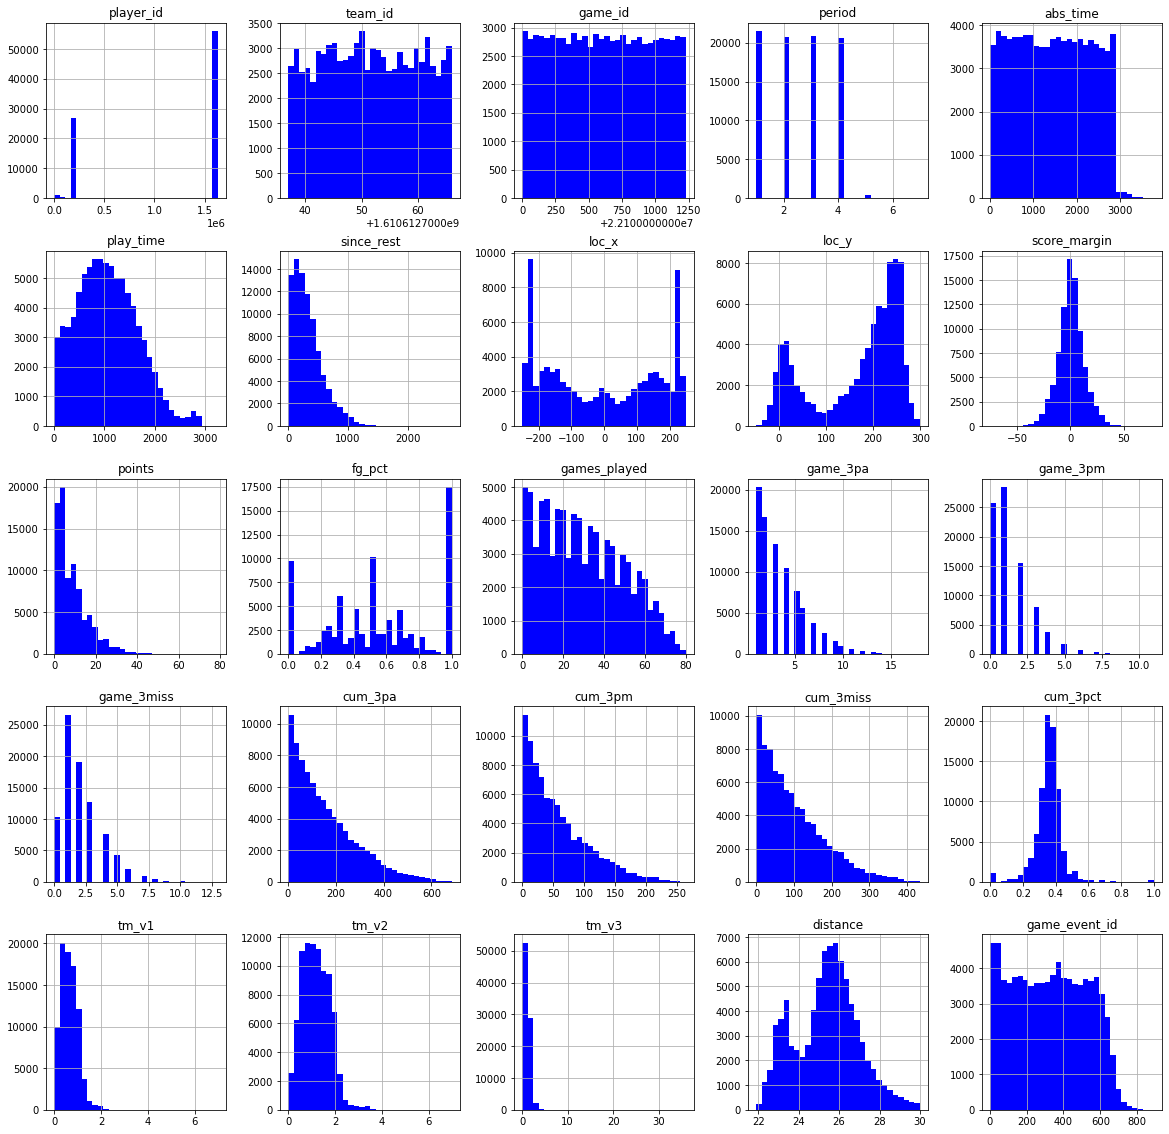

In [5]:
#what is the shape of the numeric data? 
explore.univariate(df)

### Takeaways:
- Play and rest times have clear right-skewed data.
- it is interesting to see that 3pt shots are happening more often in certain locations on the court. (see loc_x)
- score margin seems to be normally distributed
- points made by player are right skewed

### Splitting data on train, validate, test to keep integrity of data and only predict on a portion of the data.

In [4]:
#checking out what train looks like:
X_train_exp.head()

,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,fg_pct,shot_result,games_played,game_3pa,game_3pm,game_3miss,cum_3pa,cum_3pm,cum_3miss,cum_3pct,tm_v1,tm_v2,tm_v3,distance,game_event_id,shot_made_flag
77133,Cassius Winston,1630216,Washington Wizards,1610612764,22100876,False,4,2398,2384.8,238.0,205,159,L Below Break/Corner,Jump Shot,-3,3,1.00,Made Shot,3,1,1,0,5,2,3,0.400000,0.200000,0.350000,0.333333,25.943400,538,1
10088,Devonte' Graham,1628984,New Orleans Pelicans,1610612740,22100352,False,1,377,377.0,377.0,161,227,R Above Break,Pullup Jump shot,5,0,0.00,Missed Shot,22,1,0,1,168,59,109,0.351190,0.900880,1.733049,1.388512,27.829840,62,0
64509,Jock Landale,1629111,San Antonio Spurs,1610612759,22101007,True,2,769,769.0,500.0,136,225,R Above Break,Jump Shot,-9,6,0.60,Missed Shot,31,2,0,2,67,21,46,0.313433,0.205690,0.430970,0.299592,26.290873,180,0
28690,Marcus Morris Sr.,202694,Los Angeles Clippers,1610612746,22100581,False,3,1993,1728.0,1152.0,-96,246,Center,Jump Shot,-9,17,0.32,Made Shot,17,6,3,3,95,35,60,0.368421,0.716374,1.330409,1.134259,26.406817,434,1
39117,Pat Connaughton,1626192,Milwaukee Bucks,1610612749,22100060,True,1,71,71.0,71.0,229,-5,R Below Break/Corner,Jump Shot,-1,3,0.00,Made Shot,4,2,1,1,26,11,15,0.423077,0.930769,1.565385,1.613333,22.905458,16,1


### Exploring Target Variable: shot result

In [8]:
#looking at values:
df.shot_result.value_counts()

Missed Shot    54152
Made Shot      30076
Name: shot_result, dtype: int64

In [9]:
#putting into percentages:
df.shot_result.value_counts(normalize=True)

Missed Shot    0.642922
Made Shot      0.357078
Name: shot_result, dtype: float64

In [10]:
#looking at overall Made shot rate:
made_shot_rate=df.shot_result.value_counts(normalize=True)[1]

### Overall Made shot rate is 36%

I want to see the rates based on:
- Player(missed/made)
- Team
- Game
- Shot type
- Period

In [11]:
#using a function by Stephen FitzSimon that takes in a predicted outcome
#and returns the rate based on the feature against target variable:

def get_pct_outcome(df, shot_cols = ['player']):
    outputs = []
    for cat in shot_cols:
        for subcat in list(df[cat].unique()):
            for outcome in list(df['shot_result'].unique()):
                output = {
                    'player_name': cat,
                    'sub_col': subcat,
                    'outcome': outcome,
                    'total_shots_made':(df[df[cat]==subcat].shot_result == outcome).sum(),
                    'proportion': (df[df[cat]==subcat].shot_result == outcome).mean()
                }
                outputs.append(output)
    return pd.DataFrame(outputs)

get_pct_outcome(df)

,player_name,sub_col,outcome,total_shots_made,proportion
0,player,Bogdan Bogdanovic,Made Shot,169,0.373894
1,player,Bogdan Bogdanovic,Missed Shot,283,0.626106
2,player,Cam Reddish,Made Shot,65,0.357143
3,player,Cam Reddish,Missed Shot,117,0.642857
4,player,Cameron Oliver,Made Shot,1,0.333333
...,...,...,...,...,...
1105,player,Miles Bridges,Missed Shot,301,0.661538
1106,player,P.J. Washington,Made Shot,110,0.370370
1107,player,P.J. Washington,Missed Shot,187,0.629630
1108,player,Terry Rozier,Made Shot,219,0.374359


In [5]:
df

,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,fg_pct,shot_result,games_played,game_3pa,game_3pm,game_3miss,cum_3pa,cum_3pm,cum_3miss,cum_3pct,tm_v1,tm_v2,tm_v3,distance,game_event_id
0,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,1,226,226.0,226.0,228,64,R Below Break/Corner,Jump Shot,-3,3,1.00,Made Shot,0,1,1,0,1,1,0,1.000000,1.000000,1.000000,0.000000,23.681216,42
1,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,1,253,253.0,253.0,91,232,R Above Break,Jump Shot,0,6,1.00,Made Shot,0,2,2,0,2,2,0,1.000000,2.000000,2.000000,0.000000,24.920875,47
2,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,3,1580,867.0,140.0,228,69,R Below Break/Corner,Jump Shot,11,9,0.67,Made Shot,0,3,3,0,3,3,0,1.000000,3.000000,3.000000,0.000000,23.821209,362
3,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,3,1896,1183.0,456.0,134,210,R Above Break,Jump Shot,18,9,0.75,Missed Shot,0,4,3,1,4,3,1,0.750000,2.250000,2.625000,9.000000,24.911042,433
4,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,4,2411,1308.0,19.0,-148,203,Center,Jump Shot,23,9,0.50,Missed Shot,0,5,3,2,5,3,2,0.600000,1.800000,2.400000,4.500000,25.122301,548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84223,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,3,1470,1069.0,500.0,-210,141,L Above Break,Jump Shot,2,5,0.25,Missed Shot,72,5,1,4,581,215,366,0.370052,1.089878,2.017542,1.730107,25.294466,351
84224,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,4,2366,1538.0,15.0,-228,31,R Center,Fadeaway Jump Shot,6,12,0.33,Made Shot,72,6,2,4,582,216,366,0.371134,1.098150,2.028527,1.746238,23.009781,565
84225,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,4,2393,1565.0,42.0,-228,-7,R Center,Fadeaway Jump Shot,9,15,0.38,Made Shot,72,7,3,4,583,217,366,0.372213,1.106440,2.039522,1.762445,22.810743,571
84226,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,4,2566,1738.0,215.0,-232,1,R Center,Fadeaway Jump Shot,14,31,0.58,Made Shot,72,8,4,4,584,218,366,0.373288,1.114749,2.050525,1.778726,23.200216,603


In [12]:
#creating an object to ask questions on:
proportion_df = get_pct_outcome(df)

# Regular Season Leaders

### Which players have the higher 3pt shot 'Made  Shot' rates?

In [13]:
top_3pt_shooters = proportion_df[(proportion_df.proportion > made_shot_rate) & (proportion_df.outcome == 'Made Shot')]
top_3pt_shooters[top_3pt_shooters.total_shots_made >= 87].sort_values(by='proportion', ascending=False).head(60)

,player_name,sub_col,outcome,total_shots_made,proportion
394,player,Luke Kennard,Made Shot,187,0.450602
734,player,Tyrese Maxey,Made Shot,128,0.439863
984,player,Desmond Bane,Made Shot,226,0.437984
198,player,Lonzo Ball,Made Shot,110,0.428016
740,player,Cameron Johnson,Made Shot,165,0.426357
400,player,Norman Powell,Made Shot,104,0.424490
592,player,Seth Curry,Made Shot,156,0.423913
704,player,Tyrese Haliburton,Made Shot,153,0.423823
838,player,Doug McDermott,Made Shot,108,0.421875
584,player,Kyrie Irving,Made Shot,95,0.418502


### What is the average of 3pt 'Made Shots' per season?

In [14]:
#determining average of 3pt shots made per season:
top_3pt_shooters.total_shots_made.mean()

86.22815533980582

### Takeaways:
This gives us a good list of players that are shooting higher than the 35.7% made-shot rate of the NBA overall.

I'll take out the the 1 shot-wonders however, so as not to skew the data.

In [15]:
#looking at value_counts()
top_3pt_shooters.total_shots_made.value_counts()

1      9
4      6
15     5
80     4
44     4
      ..
264    1
204    1
43     1
141    1
219    1
Name: total_shots_made, Length: 126, dtype: int64

_____________________________________________

### Which teams have the highest rate of making 3pt shots?

In [16]:
### Looking a proportions of 3pt shots based on teams:
def get_pct_outcome(df, shot_cols = ['col']):
    outputs = []
    for cat in shot_cols:
        for subcat in list(df[cat].unique()):
            for outcome in list(df['shot_result'].unique()):
                output = {
                    'main_category': cat,
                    'sub_category': subcat,
                    'outcome': outcome,
                    'total_shots_made':(df[df[cat]==subcat].shot_result == outcome).sum(),
                    'proportion': (df[df[cat]==subcat].shot_result == outcome).mean()
                }
                outputs.append(output)
    return pd.DataFrame(outputs)

get_pct_outcome(df, shot_cols= ['team'])

,main_category,sub_category,outcome,total_shots_made,proportion
0,team,Atlanta Hawks,Made Shot,1004,0.379871
1,team,Atlanta Hawks,Missed Shot,1639,0.620129
2,team,New York Knicks,Made Shot,1078,0.359933
3,team,New York Knicks,Missed Shot,1917,0.640067
4,team,Los Angeles Lakers,Made Shot,958,0.347605
5,team,Los Angeles Lakers,Missed Shot,1798,0.652395
6,team,Indiana Pacers,Made Shot,985,0.348549
7,team,Indiana Pacers,Missed Shot,1841,0.651451
8,team,Chicago Bulls,Made Shot,867,0.373546
9,team,Chicago Bulls,Missed Shot,1454,0.626454


In [17]:
#creating an object to apply to teams:
team_prop_df = get_pct_outcome(df, shot_cols= ['team'])

In [18]:
# result of top teams that make 3pt shots:
top_3pt_teams = team_prop_df[(team_prop_df.proportion > made_shot_rate) & (team_prop_df.outcome == 'Made Shot')]
top_3pt_teams.sort_values(by='proportion', ascending=False)

,main_category,sub_category,outcome,total_shots_made,proportion
22,team,Miami Heat,Made Shot,1093,0.384995
0,team,Atlanta Hawks,Made Shot,1004,0.379871
44,team,Los Angeles Clippers,Made Shot,1037,0.378744
8,team,Chicago Bulls,Made Shot,867,0.373546
48,team,Golden State Warriors,Made Shot,1145,0.373329
42,team,Milwaukee Bucks,Made Shot,1139,0.368251
36,team,Philadelphia 76ers,Made Shot,932,0.367798
18,team,Phoenix Suns,Made Shot,945,0.367418
38,team,Charlotte Hornets,Made Shot,1113,0.367327
16,team,Utah Jazz,Made Shot,1173,0.365193


______________________

### Which Shot types have higher 3pt shot rates?

In [19]:
shot_type_prop = get_pct_outcome(df, shot_cols= ['shot_type'])
best_shot_types = shot_type_prop[(shot_type_prop.proportion > made_shot_rate) & (shot_type_prop.outcome == 'Made Shot')]
best_shot_types.sort_values(by='proportion', ascending=False)

,main_category,sub_category,outcome,total_shots_made,proportion
20,shot_type,Jump Bank Shot,Made Shot,85,0.521472
6,shot_type,Running Jump Shot,Made Shot,1093,0.419578
10,shot_type,Running Pull-Up Jump Shot,Made Shot,551,0.403072
26,shot_type,Driving Floating Bank Jump Shot,Made Shot,2,0.400000
16,shot_type,Step Back Bank Jump Shot,Made Shot,11,0.392857


________________

### Which zones have higher rates of shots made?

In [20]:
zone_prop = get_pct_outcome(df, shot_cols= ['zone'])
best_zones = zone_prop[(zone_prop.proportion > made_shot_rate) & (zone_prop.outcome == 'Made Shot')]
best_zones.sort_values(by='proportion', ascending=False)

,main_category,sub_category,outcome,total_shots_made,proportion
10,zone,R Center,Made Shot,4538,0.383471
0,zone,R Below Break/Corner,Made Shot,4114,0.380574


________________________________

In [6]:
X_train_exp.head()

,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,fg_pct,shot_result,games_played,game_3pa,game_3pm,game_3miss,cum_3pa,cum_3pm,cum_3miss,cum_3pct,tm_v1,tm_v2,tm_v3,distance,game_event_id,shot_made_flag
77133,Cassius Winston,1630216,Washington Wizards,1610612764,22100876,False,4,2398,2384.8,238.0,205,159,L Below Break/Corner,Jump Shot,-3,3,1.00,Made Shot,3,1,1,0,5,2,3,0.400000,0.200000,0.350000,0.333333,25.943400,538,1
10088,Devonte' Graham,1628984,New Orleans Pelicans,1610612740,22100352,False,1,377,377.0,377.0,161,227,R Above Break,Pullup Jump shot,5,0,0.00,Missed Shot,22,1,0,1,168,59,109,0.351190,0.900880,1.733049,1.388512,27.829840,62,0
64509,Jock Landale,1629111,San Antonio Spurs,1610612759,22101007,True,2,769,769.0,500.0,136,225,R Above Break,Jump Shot,-9,6,0.60,Missed Shot,31,2,0,2,67,21,46,0.313433,0.205690,0.430970,0.299592,26.290873,180,0
28690,Marcus Morris Sr.,202694,Los Angeles Clippers,1610612746,22100581,False,3,1993,1728.0,1152.0,-96,246,Center,Jump Shot,-9,17,0.32,Made Shot,17,6,3,3,95,35,60,0.368421,0.716374,1.330409,1.134259,26.406817,434,1
39117,Pat Connaughton,1626192,Milwaukee Bucks,1610612749,22100060,True,1,71,71.0,71.0,229,-5,R Below Break/Corner,Jump Shot,-1,3,0.00,Made Shot,4,2,1,1,26,11,15,0.423077,0.930769,1.565385,1.613333,22.905458,16,1


### Hypothesis Tests: 

#### Hypothesis 1): 3pt shots made have a relationship with the type of shot taken.

In [7]:
alpha = 0.05
null_hypothesis = "3pt shot result and shot type are independent"
alternative_hypothesis = "there is a relationship between 3pt shot results and shot type"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(X_train_exp.shot_result, X_train_exp.shot_type)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p



Reject the null hypothesis that 3pt shot result and shot type are independent
Sufficient evidence to move forward understanding that there is a relationship between 3pt shot results and shot type


6.242536075213413e-08

#### Hypothesis 2): 3pt shots made have a relationship with where the shot was taken.

In [8]:
alpha = 0.05
null_hypothesis = "3pt shot result and zone shot from are independent"
alternative_hypothesis = "there is a relationship between 3pt shot results and zone shot from"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(X_train_exp.shot_result, X_train_exp.zone)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p



Reject the null hypothesis that 3pt shot result and zone shot from are independent
Sufficient evidence to move forward understanding that there is a relationship between 3pt shot results and zone shot from


4.872613048323041e-10

#### Hypothesis 3): 3pt shots made have a relationship with how much time a player has been in the game.

In [9]:
shots_made_sample = X_train_exp[X_train_exp.shot_result == 'Made Shot'].play_time

<AxesSubplot:>

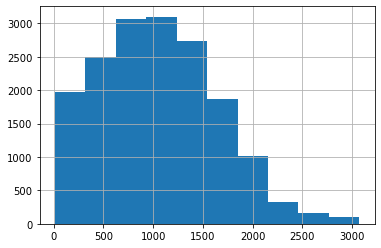

In [10]:
shots_made_sample.hist()

In [11]:
shots_missed_sample = X_train_exp[X_train_exp.shot_result == 'Missed Shot'].play_time

<AxesSubplot:>

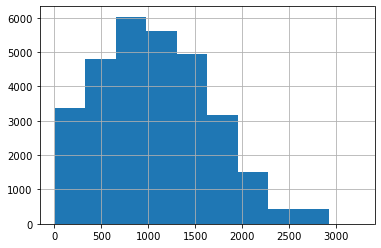

In [12]:
shots_missed_sample.hist()

(array([[2.044e+03, 2.712e+03, 3.270e+03, 3.235e+03, 2.714e+03, 1.698e+03,
         7.550e+02, 2.100e+02, 2.000e+02, 5.000e+00],
        [3.382e+03, 4.805e+03, 6.030e+03, 5.625e+03, 4.954e+03, 3.167e+03,
         1.518e+03, 4.180e+02, 4.210e+02, 4.000e+00]]),
 array([   6. ,  330.1,  654.2,  978.3, 1302.4, 1626.5, 1950.6, 2274.7,
        2598.8, 2922.9, 3247. ]),
 <a list of 2 BarContainer objects>)

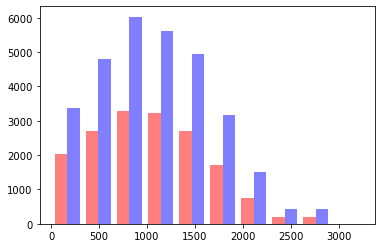

In [13]:
#putting the made vs missed shots on same histogram for comparison:
x = shots_made_sample
y = shots_missed_sample
plt.hist([x, y], color=['r','b'], alpha=0.5)

In [14]:
x.mean()

1050.0483346197236

In [15]:
y.mean()

1072.7290462999624

#### $H_0$ Mean of playtime for made shots is higher or equal to the mean of missed shots. 
#### $H_a$ Mean of playtime for made shots is less than mean of missed shots

In [16]:
alpha = .05

#checking for equal variances:
print(shots_made_sample.var())
print(shots_missed_sample.var())


347968.26812022214
354528.42978056095


Variances are not quite equal so we will use equal_var as False:

In [18]:
t, p = stats.ttest_ind(shots_made_sample, shots_missed_sample, equal_var=False)
p 

6.687480518854325e-05

### We reject the null hypothesis and found that play time does have a relationship to missed/made shots.

______________________________

#### Hypothesis 4): 3pt shots made have a relationship with how much time a player had rested prior to the shoot.

In [20]:
shots_made_rest = X_train_exp[X_train_exp.shot_result == "Made Shot"].since_rest

<AxesSubplot:>

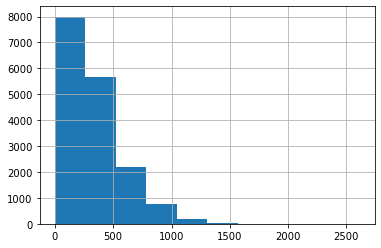

In [21]:
shots_made_rest.hist()

In [22]:
shots_missed_rest = X_train_exp[X_train_exp.shot_result == "Missed Shot"].since_rest

<AxesSubplot:>

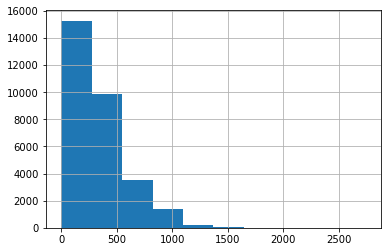

In [23]:
shots_missed_rest.hist()

The shapes look very similar. Let's look at variances:

#### $H_0$ Mean of made shots is higher or equal to the mean of missed shots. 
#### $H_a$ Mean of made shots is less than mean of missed shots.

In [24]:
alpha = .05

#checking for equal variances:
print(shots_made_rest.var())
print(shots_missed_rest.var())

59764.81340611715
62816.30713581885


In [25]:
#variances not the same so var will equal false in test:
t, p = stats.ttest_ind(shots_made_rest, shots_missed_rest, equal_var=False)
p

0.952392575344884

_____________________________________

## Rechecking with more confidence in alpha and ANOVA testing 
for Missed vs Made and play time 

I want to make sure there isn't some odd randomness happening, so I'll use both the Missed and Made shots and do an Anova test with 99% accuracy check if there isn't something odd going on between the variables.

I can tell on the histograms there is a difference happening, but maybe the 95% confidence in alpha needs to be set differently as the metrics may be close but still varying. We want to find/see that.

In [ ]:
null_hypothesis = "Amount of time played when taking a 3pt shot has no relation to when shot is made or missed"
alternative_hypothesis = "Amount of time played when taking a 3pt shot has a relation to when shot is made or missed"
alpha = 0.01 # Let's be 99% certain the result we see isn't due to chance/randomness

In [ ]:
# Isolating out made vs missed shots:
made_shots = train[train.shot_result == "Made Shot"].play_time
missed_shots = train[train.shot_result == "Missed Shot"].play_time

In [ ]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

f, p = f_oneway(made_shots, missed_shots)
p

In [ ]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that play time averages are significantly different across made or missed shots.")

______________________________

In [ ]:
df.info()

### Looking at possible linear relations:

In [ ]:
print("Is there a relationship between play_time and score_margin?")
sns.jointplot(x="play_time", y="score_margin", data=train)
plt.xlabel("Time in game")
plt.ylabel("Score Margin")
plt.show()

In [ ]:
print("Is there a relationship between play_time and points?")
sns.jointplot(x="play_time", y="points", data=train)
plt.xlabel("Time in game")
plt.ylabel("Points made")
plt.show()

In [ ]:
print("Is there a relationship between play_time and shot_result?")
sns.jointplot(x="shot_result", y="play_time", data=train)
plt.xlabel("Made or Missed Shot")
plt.ylabel("Play Time")
plt.show()

#### What about when a player rests?

Is there a relationship between resting time and shot result?


ValueError: Could not interpret value `shot_made_flag` for parameter `x`

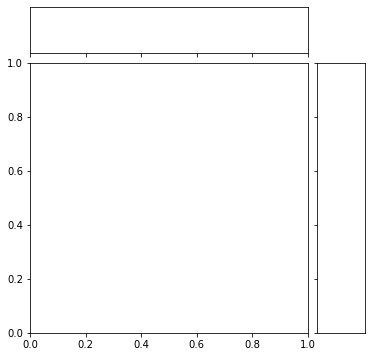

In [8]:
print("Is there a relationship between resting time and shot result?")
sns.jointplot(x="shot_made_flag", y="since_rest", data=X_train)
plt.xlabel("Made or Missed Shot")
plt.ylabel("Time since rest")
plt.show()

In [ ]:
print("Is there a relationship between time since rest and points?")
sns.jointplot(x="since_rest", y="cum_3pm", data=train)
plt.xlabel("Time since rest")
plt.ylabel("3pt shots made")
plt.show()

#### The above shows a good indicator of possible player fatigue. Points seem to go down the longer a player is in game.

#### There seems to be a point right after 1000 seconds since rest that points players are making begin to drop. I want to bin these since_rest times to see if I can look at this in a better way.

In [ ]:
#creating since_rest bins for < 1000 and >= 1000
train['rest_bin']= pd.cut(train.since_rest, [0,250,500,750,1000,2000,3000])

train.head()

In [ ]:
#I'll use a box plot to compare the rest times and points:
sns.boxplot(train.rest_bin, train.cum_3pm)
plt.show()

There is a difference, in a way I wasn't expecting. This makes it seem that players aren't making as many points when they first come back into the game from resting. There may be a point when a player needs to warm back into the game..?
I"ll look at the variances and also try a two sample, two-tailed t-test.

In [ ]:
#equal variance tes
stats.levene(train[train.since_rest <=1000].points,
            train[train.since_rest> 1000].points
            )

In [ ]:
#with unequal variances, I'll set the variance as false in t-test:
stats.ttest_ind(train[train.since_rest <=1000].points,
            train[train.since_rest> 1000].points,
            equal_var=False
            )

#### Conclusion: 
There is a significant difference of points players make depending on when they return to the game from resting.

I'll control for resting time and I'll plot shot_result and points to see if this differs.

In [ ]:
sns.scatterplot(x='points', y='shot_result',
               data=train[train.since_rest <= 1000],
               color = 'red'
               )

In [34]:
df

,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,fg_pct,shot_result,games_played,game_3pa,game_3pm,game_3miss,cum_3pa,cum_3pm,cum_3miss,cum_3pct,tm_v1,tm_v2,tm_v3,distance,game_event_id
0,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,1,226,226.0,226.0,228,64,R Below Break/Corner,Jump Shot,-3,3,1.00,Made Shot,0,1,1,0,1,1,0,1.000000,1.000000,1.000000,0.000000,23.681216,42
1,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,1,253,253.0,253.0,91,232,R Above Break,Jump Shot,0,6,1.00,Made Shot,0,2,2,0,2,2,0,1.000000,2.000000,2.000000,0.000000,24.920875,47
2,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,3,1580,867.0,140.0,228,69,R Below Break/Corner,Jump Shot,11,9,0.67,Made Shot,0,3,3,0,3,3,0,1.000000,3.000000,3.000000,0.000000,23.821209,362
3,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,3,1896,1183.0,456.0,134,210,R Above Break,Jump Shot,18,9,0.75,Missed Shot,0,4,3,1,4,3,1,0.750000,2.250000,2.625000,9.000000,24.911042,433
4,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,4,2411,1308.0,19.0,-148,203,Center,Jump Shot,23,9,0.50,Missed Shot,0,5,3,2,5,3,2,0.600000,1.800000,2.400000,4.500000,25.122301,548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84223,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,3,1470,1069.0,500.0,-210,141,L Above Break,Jump Shot,2,5,0.25,Missed Shot,72,5,1,4,581,215,366,0.370052,1.089878,2.017542,1.730107,25.294466,351
84224,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,4,2366,1538.0,15.0,-228,31,R Center,Fadeaway Jump Shot,6,12,0.33,Made Shot,72,6,2,4,582,216,366,0.371134,1.098150,2.028527,1.746238,23.009781,565
84225,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,4,2393,1565.0,42.0,-228,-7,R Center,Fadeaway Jump Shot,9,15,0.38,Made Shot,72,7,3,4,583,217,366,0.372213,1.106440,2.039522,1.762445,22.810743,571
84226,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,4,2566,1738.0,215.0,-232,1,R Center,Fadeaway Jump Shot,14,31,0.58,Made Shot,72,8,4,4,584,218,366,0.373288,1.114749,2.050525,1.778726,23.200216,603


___________

In [ ]:
print("Is there a relationship between time since rest and score_margin?")
sns.jointplot(x="since_rest", y="score_margin", data=train)
plt.xlabel("Time since rest")
plt.ylabel("Score Margin")
plt.show()

In [22]:
elite_list = ['Anthony Edwards', 'Buddy Hield', 'CJ McCollum', 'Carmelo Anthony',
       "D'Angelo Russell", 'Desmond Bane', 'Devonte Graham',
       'Donovan Mitchell', 'Duncan Robinson', 'Evan Fournier', 'Fred VanVleet',
       'Gary Trent Jr.', 'Grayson Allen', 'Jaylen Brown', 'Klay Thompson',
       'LaMelo Ball', 'LeBron James', 'Lonzo Ball', 'Luke Kennard',
       'Malik Beasley', 'Patty Mills', 'Paul George', 'Seth Curry',
       'Stephen Curry', 'Terry Rozier', 'Zach LaVine']
    

In [23]:
def e_players(elite_list):
    for name in elite_list:
        df[df['player'] == name]
    return df

In [30]:
elite_list = ['Anthony Edwards', 'Buddy Hield', 'CJ McCollum', 'Carmelo Anthony',
       "D'Angelo Russell", 'Desmond Bane', 'Devonte Graham',
       'Donovan Mitchell', 'Duncan Robinson', 'Evan Fournier', 'Fred VanVleet',
       'Gary Trent Jr.', 'Grayson Allen', 'Jaylen Brown', 'Klay Thompson',
       'LaMelo Ball', 'LeBron James', 'Lonzo Ball', 'Luke Kennard',
       'Malik Beasley', 'Patty Mills', 'Paul George', 'Seth Curry',
       'Stephen Curry', 'Terry Rozier', 'Zach LaVine']
dfs =[]

for name in elite_list:
    dfs.append(df[df['player']==name])

In [35]:
dfs = []

for elite in elite_list:
    dfs.append(df[df.player == elite])
    
elite_df = pd.concat(dfs)
elite_df

,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,fg_pct,shot_result,games_played,game_3pa,game_3pm,game_3miss,cum_3pa,cum_3pm,cum_3miss,cum_3pct,tm_v1,tm_v2,tm_v3,distance,game_event_id
39672,Anthony Edwards,1630162,Minnesota Timberwolves,1610612750,22100008,True,1,57,57.0,57.0,-100,232,Center,Running Pull-Up Jump Shot,0,0,1.00,Missed Shot,0,1,0,1,1,0,1,0.000000,0.000000,0.000000,0.000000,25.263412,13
39673,Anthony Edwards,1630162,Minnesota Timberwolves,1610612750,22100008,True,1,269,269.0,269.0,143,209,R Above Break,Pullup Jump shot,2,0,0.00,Missed Shot,0,2,0,2,2,0,2,0.000000,0.000000,0.000000,0.000000,25.323902,68
39674,Anthony Edwards,1630162,Minnesota Timberwolves,1610612750,22100008,True,1,501,501.0,501.0,-43,241,L Center,Pullup Jump shot,11,5,0.25,Made Shot,0,3,1,2,3,1,2,0.333333,0.333333,0.666667,0.500000,24.480605,128
39675,Anthony Edwards,1630162,Minnesota Timberwolves,1610612750,22100008,True,1,605,605.0,605.0,-53,247,L Center,Jump Shot,9,7,0.50,Missed Shot,0,4,1,3,4,1,3,0.250000,0.250000,0.625000,0.333333,25.262225,146
39676,Anthony Edwards,1630162,Minnesota Timberwolves,1610612750,22100008,True,2,958,663.0,50.0,-184,157,L Above Break,Jump Shot,9,10,0.43,Made Shot,0,5,2,3,5,2,3,0.400000,0.800000,1.400000,1.333333,24.187807,238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14687,Zach LaVine,203897,Chicago Bulls,1610612741,22101193,True,3,1802,1395.0,753.0,-69,240,Center,Step Back Jump shot,-22,8,0.44,Missed Shot,64,5,0,5,458,180,278,0.393013,1.088344,1.928787,1.793027,24.972185,415
14688,Zach LaVine,203897,Chicago Bulls,1610612741,22101208,True,1,174,174.0,174.0,51,247,L Center,Jump Shot,-4,3,0.00,Made Shot,65,1,1,0,459,181,278,0.394336,1.081435,1.911930,1.785535,25.221023,27
14689,Zach LaVine,203897,Chicago Bulls,1610612741,22101208,True,1,720,720.0,720.0,25,266,L Center,Fadeaway Jump Shot,-9,9,0.67,Missed Shot,65,2,1,1,460,181,279,0.393478,1.079084,1.910754,1.779135,26.717223,130
14690,Zach LaVine,203897,Chicago Bulls,1610612741,22101208,True,2,933,752.0,32.0,-119,226,Center,Step Back Jump shot,-21,9,0.40,Missed Shot,65,3,1,2,461,181,280,0.392625,1.076744,1.909584,1.772781,25.541535,179


In [36]:
elite_df.to_csv('elite.csv',index=False)

In [ ]:
df.columns

In [25]:
e_columns=['player', 'player_id', 'team', 'team_id', 'game_id', 'home', 'period',
       'abs_time', 'play_time', 'since_rest', 'loc_x', 'loc_y', 'zone',
       'shot_type', 'score_margin', 'points', 'fg_pct', 'shot_result',
       'games_played', 'game_3pa', 'game_3pm', 'game_3miss', 'cum_3pa',
       'cum_3pm', 'cum_3miss', 'cum_3pct', 'tm_v1', 'tm_v2', 'tm_v3',
       'distance', 'game_event_id']

In [26]:
elite_team= pd.DataFrame(dfs, columns = e_columns )

ValueError: Shape of passed values is (26, 1), indices imply (26, 31)